In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

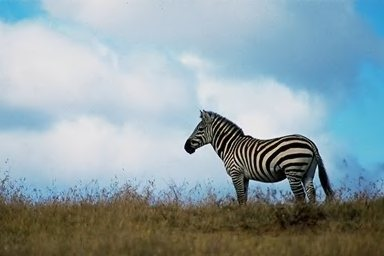

In [4]:
real_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

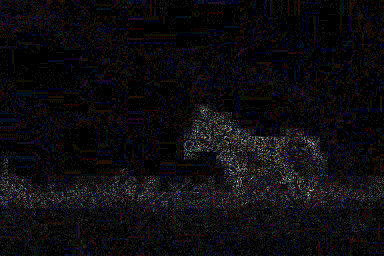

In [5]:
convert_to_ela_image(real_image_path, 90)

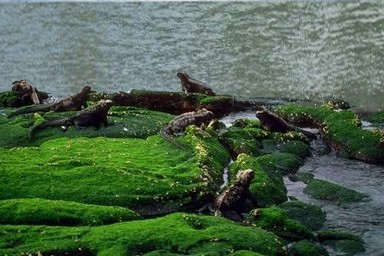

In [6]:
fake_image_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Image.open(fake_image_path)

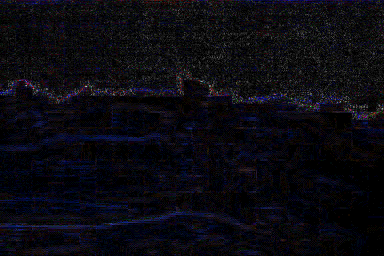

In [7]:
convert_to_ela_image(fake_image_path, 90)

In [8]:
image_size = (128, 128)

In [9]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [11]:
import random
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [12]:
path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [13]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,  random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3123 3123
1041 1041


In [15]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [16]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [17]:
epochs = 30
batch_size = 32

In [18]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [21]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30


2024-08-23 15:48:54.721398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - 8s 31ms/step - loss: 0.5426 - accuracy: 0.6750 - val_loss: 0.3683 - val_accuracy: 0.9011
Epoch 2/30
98/98 [==============================] - 3s 26ms/step - loss: 0.3488 - accuracy: 0.8761 - val_loss: 0.3016 - val_accuracy: 0.9126
Epoch 3/30
98/98 [==============================] - 3s 26ms/step - loss: 0.3194 - accuracy: 0.8998 - val_loss: 0.2715 - val_accuracy: 0.9241
Epoch 4/30
98/98 [==============================] - 3s 26ms/step - loss: 0.3033 - accuracy: 0.9027 - val_loss: 0.2510 - val_accuracy: 0.9251
Epoch 5/30
98/98 [==============================] - 3s 26ms/step - loss: 0.2796 - accuracy: 0.9030 - val_loss: 0.2547 - val_accuracy: 0.9164
Epoch 6/30
98/98 [==============================] - 3s 26ms/step - loss: 0.2739 - accuracy: 0.9033 - val_loss: 0.2274 - val_accuracy: 0.9289
Epoch 7/30
98/98 [==============================] - 3s 26ms/step - loss: 0.2634 - accuracy: 0.9078 - val_loss: 0.2285 - val_accuracy: 0.9260
Epoch 8/30
98/98 [======

In [22]:
model.save('model_casia_run1.h5')

In [23]:
# Evaluate the model on training and validation data
train_loss, train_accuracy = model.evaluate(X_train, Y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))


Training Accuracy: 96.99%
Validation Accuracy: 90.30%


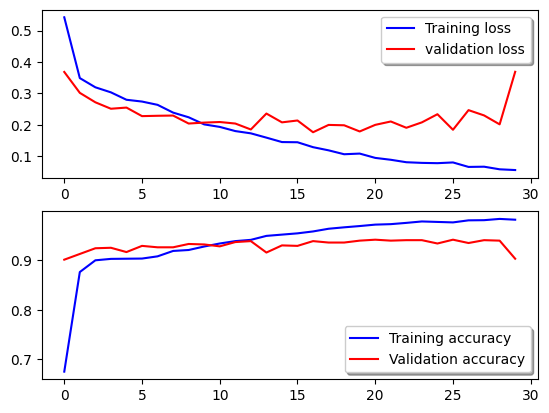

In [24]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

33/33 [==============================] - 0s 7ms/step


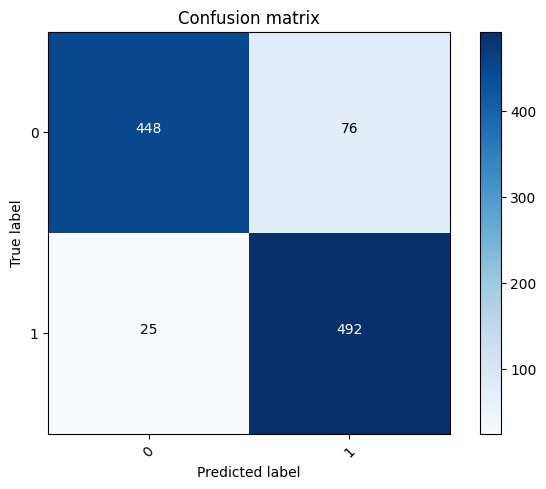

In [26]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [27]:
class_names = ['Fake Image', 'Real Image']

33/33 [==============================] - 0s 7ms/step


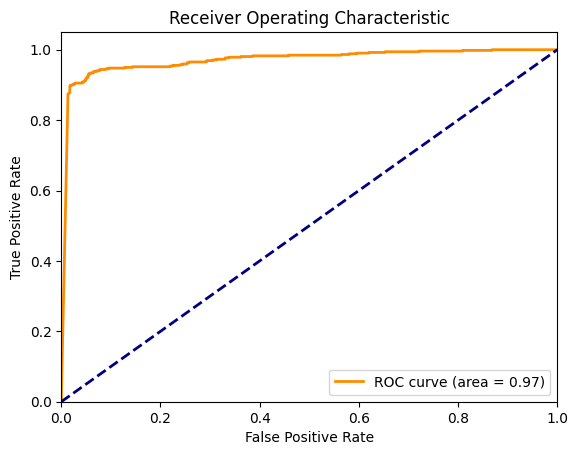

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict the probability scores for the positive class
Y_score = model.predict(X_val)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(Y_true, Y_score[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [29]:
real_image_path = '/kaggle/input/tp-img-for-test/1.png'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]}')
print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 47ms/step
Class: Real Image
Confidence: 84.09


In [32]:
real_image_path = '/kaggle/input/tp-img-for-test/YMFECLDX4ZMBZPERCWPMM6IFCQ.png'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]}')
print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 22ms/step
Class: Fake Image
Confidence: 98.65
